# Исследование оттока клиентов фитнес-клуба

# Описание проекта

Сеть фитнес-центров «Культурист-датасаентист» разрабатывает стратегию взаимодействия с клиентами на основе аналитических данных.

Распространённая проблема фитнес-клубов и других сервисов — отток клиентов. Как понять, что клиент больше не с вами? Можно записать в отток тех, кто попросил закрыть договор или удалил аккаунт. Однако клиенты не всегда уходят демонстративно: чаще перестают пользоваться сервисом тихо.

Индикаторы оттока зависят от специфики отрасли. Когда пользователь редко, но стабильно закупается в интернет-магазине — не похоже, что он «отвалился». А вот если две недели не заходит на канал с ежедневно обновляемым контентом, дела плохи: подписчик заскучал и, кажется, оставил вас.

Для фитнес-центра можно считать, что клиент попал в отток, если за последний месяц ни разу не посетил спортзал. Конечно, не исключено, что он уехал на Бали и по приезде обязательно продолжит ходить на фитнес. Однако чаще бывает наоборот. Если клиент начал новую жизнь с понедельника, немного походил в спортзал, а потом пропал — скорее всего, он не вернётся.

Чтобы бороться с оттоком, отдел по работе с клиентами «Культуриста-датасаентиста» перевёл в электронный вид множество клиентских анкет.

Задача — провести анализ и подготовить план действий по удержанию клиентов.

А именно:

научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
проанализировать основные признаки, наиболее сильно влияющие на отток;
сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:

1. выделить целевые группы клиентов;
2. предложить меры по снижению оттока;
3. определить другие особенности взаимодействия с клиентами.   

# Описание данных
«Культурист-датасаентист» предоставил сведения в csv-файлах. Заказчик подготовил данные, которые содержат данные на месяц до оттока и факт оттока на определённый месяц. Набор данных включает следующие поля:

`Churn` — факт оттока в текущем месяце;    
**Текущие поля в датасете:**    
**Данные клиента за предыдущий до проверки факта оттока месяц:**   
`gender` — пол;    
`Near_Location` — проживание или работа в районе, где находится фитнес-центр;     
`Partner` — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);    
`Promo_friends` — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);    
`Phone` — наличие контактного телефона;     
`Age` — возраст;     
`Lifetime` — время с момента первого обращения в фитнес-центр (в месяцах).    
**Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:**   
`Contract_period` — длительность текущего действующего абонемента (месяц, 3 месяца, 6 месяцев, год);     
`Month_to_end_contract` — срок до окончания текущего действующего абонемента (в месяцах);    
`Group_visits` — факт посещения групповых занятий;    
`Avg_class_frequency_total` — средняя частота посещений в неделю за все время с начала действия абонемента;    
`Avg_class_frequency_current_month` — средняя частота посещений в неделю за предыдущий месяц;    
`Avg_additional_charges_total` — суммарная выручка от других услуг фитнес-центра: кафе, спорт-товары, косметический и массажный салон.     

# Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import transforms
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans

## Изучение данных и подготовка к анализу

In [2]:
# функция для ознакомления с данными
def dataframeinfo(df):
    display(df.head(5))
    print('-' * 100, '\n**Типы данных**')
    print(df.info())
    print('-' * 100, '\n**Кол-во пропусков**')
    print(df.isna().sum())
    print('-' * 100,
          '\n**Кол-во дубликатов** {}'.format(df.duplicated().sum()))
    print('-' * 100, '\n**Статистические данные**')
    display(df.describe())

In [3]:
df = pd.read_csv('gym_churn.csv')
dataframeinfo(df)

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


---------------------------------------------------------------------------------------------------- 
**Типы данных**
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Li

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


**Вывод:**     
1.Название столбцов: перевести в нижний регистр;    
2.Тип данных столбца `Month_to_end_contract` перевести в фомат int64;    
3.Дубликаты, пропуски и аномалии отсутсвуют.

### Преобразование данных

#### Корректировка названия столбцов

In [4]:
# перевод столбцов в нижний регистр
df.columns = df.columns.str.lower()

#### Изменение типов данных

In [5]:
df['month_to_end_contract'] = df['month_to_end_contract'].astype(np.int64)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   near_location                      4000 non-null   int64  
 2   partner                            4000 non-null   int64  
 3   promo_friends                      4000 non-null   int64  
 4   phone                              4000 non-null   int64  
 5   contract_period                    4000 non-null   int64  
 6   group_visits                       4000 non-null   int64  
 7   age                                4000 non-null   int64  
 8   avg_additional_charges_total       4000 non-null   float64
 9   month_to_end_contract              4000 non-null   int64  
 10  lifetime                           4000 non-null   int64  
 11  avg_class_frequency_total          4000 non-null   float

## Исследовательский анализ данных (EDA)

In [6]:
df.groupby('churn').agg({'mean', 'std', 'var'}).T

churn                                             0            1
gender                            std      0.499984     0.500118
                                  var      0.249984     0.250118
                                  mean     0.510037     0.510839
near_location                     std      0.332933     0.422217
                                  var      0.110844     0.178267
                                  mean     0.873086     0.768143
partner                           std      0.498914     0.478837
                                  var      0.248915     0.229285
                                  mean     0.534195     0.355325
promo_friends                     std      0.478144     0.387495
                                  var      0.228622     0.150152
                                  mean     0.353522     0.183789
phone                             std      0.295040     0.296204
                                  var      0.087049     0.087737
                                  mean     0.903709     0.902922
contract_period                   std      4.716942     2.132371
                                  var     22.249545     4.547004
                                  mean     5.747193     1.728558
group_visits                      std      0.498795     0.443448
                                  var      0.248796     0.196646
                                  mean     0.464103     0.268615
age                               std      3.009933     2.895163
                                  var      9.059694     8.381968
                                  mean    29.976523    26.989632
avg_additional_charges_total      std     99.801599    77.696419
                                  var   9960.359130  6036.733541
                                  mean   158.445715   115.082899
month_to_end_contract             std      4.363522     1.964593
                                  var     19.040323     3.859627
                                  mean     5.283089     1.662582
lifetime                          std      3.874780     1.110799
                                  var     15.013921     1.233873
                                  mean     4.711807     0.990575
avg_class_frequency_total         std      1.016006     0.694705
                                  var      1.032269     0.482615
                                  mean     2.024876     1.474995
avg_class_frequency_current_month std      1.018994     0.770237
                                  var      1.038348     0.593265
                                  mean     2.027882     1.044546

In [7]:
# посчитаем долю charn 0
churn_1 = df.loc[df['churn'] == 1]
print('Процент оттока клиентов в текущем месяце: {:.0%}'.format(
    churn_1['churn'].count() / len(df)))

Процент оттока клиентов в текущем месяце: 27%


**Вывод**   
- всего клиентов = 4000 человек из них 27% имеют статус оттока "Да";
- мужчин и женщин примерно одинаковое кол-во;
- проживают или работаю в районе фитнес-центра - 87% и 76% из оттока;
- являются партнёрами клуба - 35% и 18% из оттока;
- чаще приобретают посещение на 6 мес., но высокое стандартное отклоение говорит, что это не самый популярный продукт. А те кто отказался от услуг фитнес-клуба, чаще приобретают на более короткие периоды: 1 или 3 мес.
- групповые занятие посещают около 50%, а те кто оказался в оттоке, посещает всего 26%. У них явно изначально была не высокая мотивация;
- средний возраст посетителей: 27-30  лет;
- выручка от других услуг находится в диапазоне от 115 до 160 у.е.; 
- время с момента первого обращения в фитнес-центр: 5 мес. 1 мес. из оттока. 
- средняячатсота посещений в неделю за все время с начала действия абонемента - 2 и 1 из оттока.    

Глобально те кто в оттоке, реже пользуются всеми услугами фитнес-центра, не увеличивают средний чек, приобретают абонементы на более короткий срок, а также посещают спортзалв два раза реже. Т.е они изначально не были нацеленены на долгосрочные отношения. 


### Cтолбчатые гистограммы и распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток);

In [8]:
df_plot = df.copy()  # копирование df
df_plot['churn'] = df_plot['churn'].replace(
    [1, 0], ['churn', 'active'])  # новое имя для 0 и 1
df_plot.columns

Index(['gender', 'near_location', 'partner', 'promo_friends', 'phone',
       'contract_period', 'group_visits', 'age',
       'avg_additional_charges_total', 'month_to_end_contract', 'lifetime',
       'avg_class_frequency_total', 'avg_class_frequency_current_month',
       'churn'],
      dtype='object')

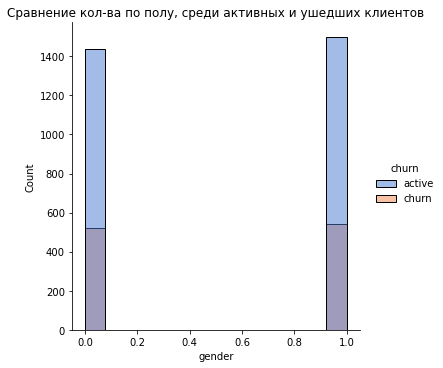

In [9]:
sns.displot(data=df_plot, x='gender', hue='churn', palette='muted')
plt.title('Сравнение кол-ва по полу, среди активных и ушедших клиентов')
plt.show()

Отток мужчин и женщин примерно одинаков

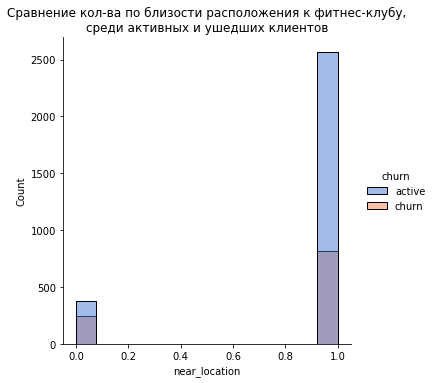

In [10]:
sns.displot(data=df_plot, x='near_location', hue='churn', palette='muted')
plt.title(
    'Сравнение кол-ва по близости расположения к фитнес-клубу,\nсреди активных и ушедших клиентов'
)
plt.show()

Клиенты уходят в обоих вариантах, но делать выводы о точном влиянии оттдаленности, пока рано.

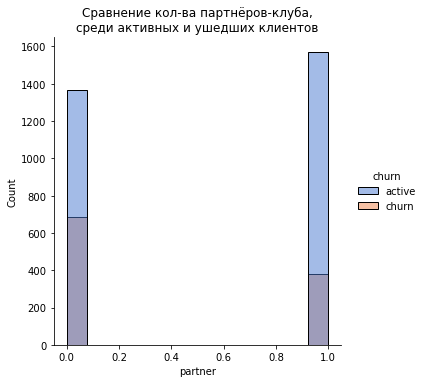

In [11]:
sns.displot(data=df_plot, x='partner', hue='churn', palette='muted')
plt.title(
    'Сравнение кол-ва партнёров-клуба,\nсреди активных и ушедших клиентов')
plt.show()

НЕ "партнёры клуба" чаще отказывают от абонементов.

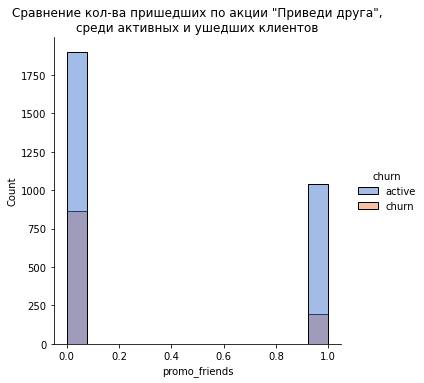

In [12]:
sns.displot(data=df_plot, x='promo_friends', hue='churn', palette='muted')
plt.title(
    'Сравнение кол-ва пришедших по акции "Приведи друга",\nсреди активных и ушедших клиентов'
)
plt.show()

Не пришедшие по промо-акции, уходят значително чаще.

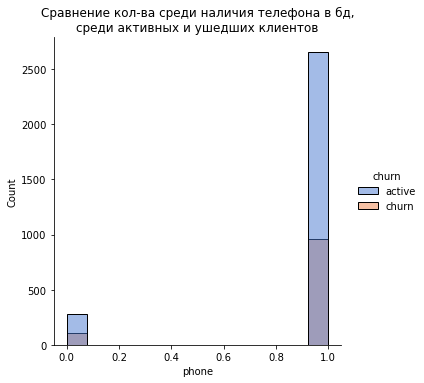

In [13]:
sns.displot(data=df_plot, x='phone', hue='churn', palette='muted')
plt.title(
    'Сравнение кол-ва среди наличия телефона в бд,\nсреди активных и ушедших клиентов'
)
plt.show()

По наличию телефона делать вывод неправильно, так как на данный момент нет информации, высылаем мы какие-то сообщение и вообще как используем номер телефона клиента.

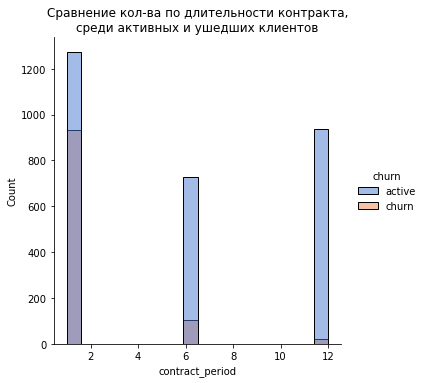

In [14]:
sns.displot(data=df_plot, x='contract_period', hue='churn', palette='muted')
plt.title(
    'Сравнение кол-ва по длительности контракта,\nсреди активных и ушедших клиентов'
)
plt.show()

Больше длительность абонемента, меньше отток.

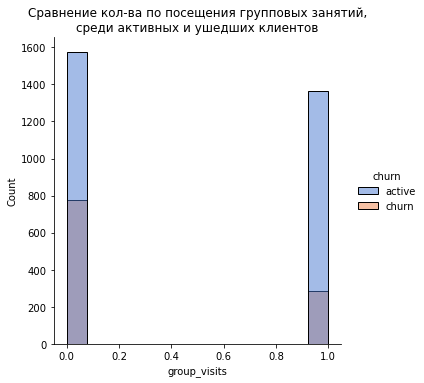

In [15]:
sns.displot(data=df_plot, x='group_visits', hue='churn', palette='muted')
plt.title(
    'Сравнение кол-ва по посещения групповых занятий,\nсреди активных и ушедших клиентов'
)
plt.show()

Те кто не посещает групповые занятие, чаще отказываются от услуг клуба.

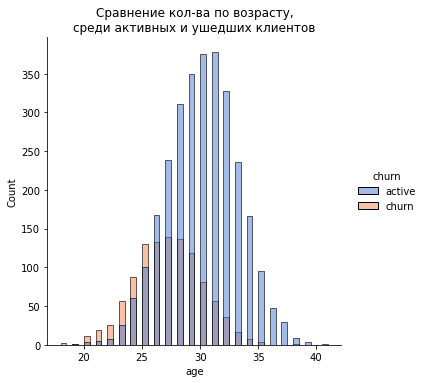

In [16]:
sns.displot(data=df_plot, x='age', hue='churn', palette='muted')
plt.title('Сравнение кол-ва по возрасту,\nсреди активных и ушедших клиентов')
plt.show()

Клиенты до 26 лет, чаще расторгают договор. А клиенты старше, привязываются к фитнес-клубу.

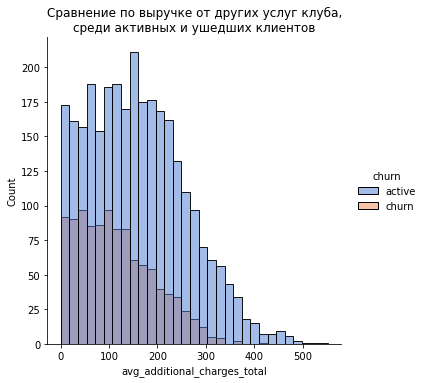

In [17]:
sns.displot(data=df_plot,
            x='avg_additional_charges_total',
            hue='churn',
            palette='muted')
plt.title(
    'Сравнение по выручке от других услуг клуба,\nсреди активных и ушедших клиентов'
)
plt.show()

Активные клиенты больше всего тратят личных финасов на дургие платные услуги клуба. Расходы примерно составляюи до 150 у.е. далее уже чек снижается.   
Клиенты из оттока тоже приобретают дополнительные услуги, но реже почти в 2, а где-то и в 3 раза, а расходы составляют до 120 у.е.    
Нет клиентов, которые бы ничего не приобрели.   
Некоторые активные клиенты, расходуют более 400 у.е., но их всего около 50.

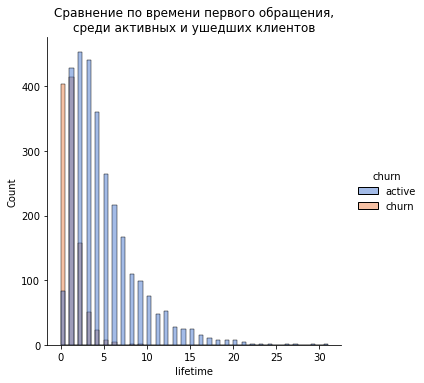

In [18]:
sns.displot(data=df_plot, x='lifetime', hue='churn', palette='muted')
plt.title(
    'Сравнение по времени первого обращения,\nсреди активных и ушедших клиентов'
)
plt.show()

Много клиентов уходит в первые три месяца. Далее отток почти не наблюдается.

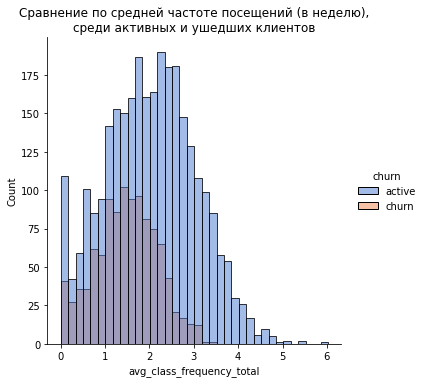

In [19]:
sns.displot(data=df_plot,
            x='avg_class_frequency_total',
            hue='churn',
            palette='muted')
plt.title(
    'Сравнение по средней частоте посещений (в неделю),\nсреди активных и ушедших клиентов'
)
plt.show()

Ушедшие клиенты посещали клуб до 1,5 раза в неделю, когда как активные клиенты стараются посещать 2.5 раза в неделю.

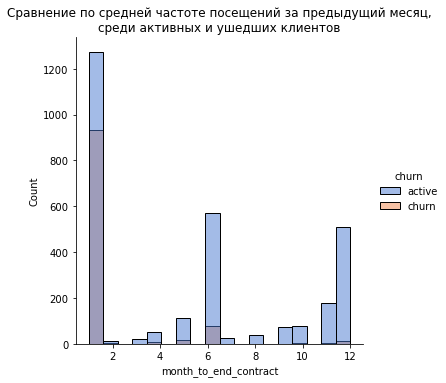

In [20]:
sns.displot(data=df_plot,
            x='month_to_end_contract',
            hue='churn',
            palette='muted')
plt.title(
    'Сравнение по средней частоте посещений за предыдущий месяц,\nсреди активных и ушедших клиентов'
)
plt.show()

У большиства контракт заканчивается максимум через месяц. И большую их часть уже не смогли вернуть обратно в данный фитнес-клуб.

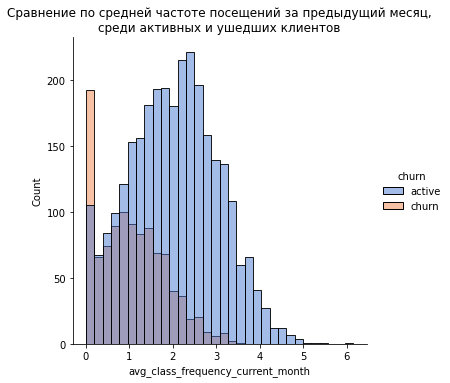

In [21]:
sns.displot(data=df_plot,
            x='avg_class_frequency_current_month',
            hue='churn',
            palette='muted')
plt.title(
    'Сравнение по средней частоте посещений за предыдущий месяц,\nсреди активных и ушедших клиентов'
)
plt.show()

Ушедшие активно занимались в первые недели после приобретения абонемента, а некоторые даже в первый месяц. Но активные клиенты в "строю" держаться гораздо дольше, примерно до 3 месяцев. А истинных любителей спорта, не так и много.

### Матрица корреляции

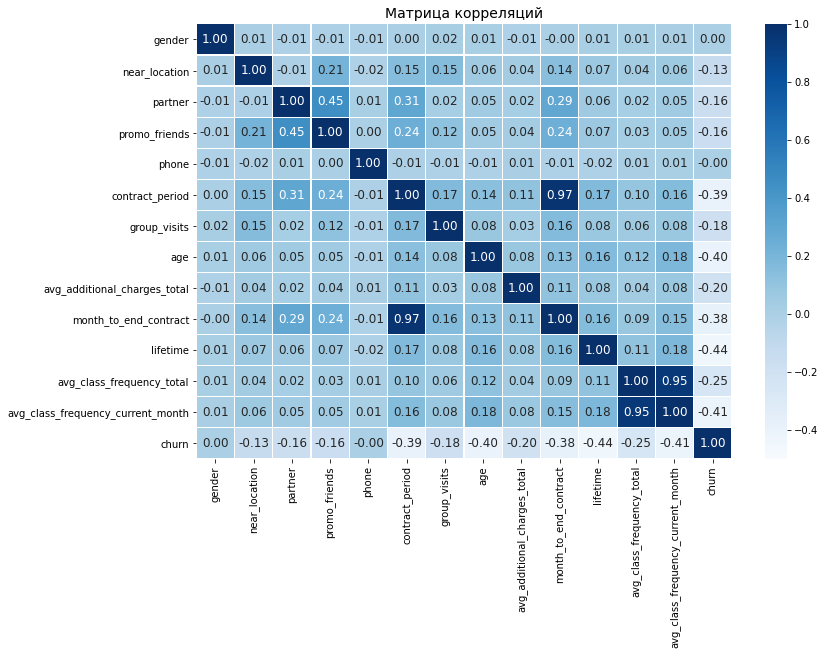

In [22]:
cm = df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(cm,
            annot=True,
            fmt='.2f',
            vmin=-0.5,
            linewidths=.1,
            annot_kws={'size': 12},
            cmap='Blues')
plt.title('Матрица корреляций', fontsize=14)
plt.show()

Сильно коррелируют следующие признаки:    
- срок окончания действующего абонемента и продолжительность абонемента;    
- средняя частота посещений в неделю за предыдущий месяц и суммарная выручка от других услуг фитнес-клуба: кафе, спорт-товары, косметический и массажный салон.    

Данные признаки нужно удалить, чтобы они не мешали обучать модель.

## Построение модели прогнозирования оттока клиентов

Целевым значением будет являтся — факт оттока клиента в текущем месяце.  

Избавляемся от мультиколлениарности.

In [23]:
df_mod = df.copy()
df_mod = df_mod.drop(['month_to_end_contract', 'avg_class_frequency_total'],
                     axis=1)

Делим признаки на матрицу `X` и целевую переменную `y` и стандартизируем данные.

In [24]:
#разделим наши данные на признаки (матрица X) и целевую переменную (y)
X = df_mod.drop('churn', axis=1)
y = df_mod['churn']
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=0)
# стандартизируем данные
scaler = StandardScaler()
scaler.fit(X_train)
X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)

###  Обучение модели на train-выбоке
#### Способ 1. Логистическая решраессия

In [25]:
# задается алгоритм для модели логистической регрессии
lr_model = LogisticRegression(random_state=0)
# обучение модели
lr_model.fit(X_train_st, y_train)
# использование уже обученной модели, чтобы сделать прогнозы
lr_predictions = lr_model.predict(X_test_st)
lr_probabilities = lr_model.predict_proba(X_test_st)[:, 1]

#### Способ 2. Случайный лес

In [26]:
# задаётся алгоритм для новой модели на основе алгоритма случайного леса
rf_model = RandomForestClassifier(n_estimators=100, random_state=0)
# обучение модели случайного леса
rf_model.fit(X_train_st, y_train)
# использование уже обученной модели, чтобы сделать прогнозы
rf_predictions = rf_model.predict(X_test_st)
rf_probabilities = rf_model.predict_proba(X_test_st)[:, 1]

### Оцкенка метрик для обеих моделей на валидационной выборке    
 - accurancy
 - precision
 - recal
 - F1_score
 - ROC_AUC

In [27]:
# функция расчёта и вывода метрик на экран
def print_all_metrics(y_true, y_pred, y_proba, title):
    print(title)
    print('\tAccuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))
    print('\tPrecision: {:.2f}'.format(precision_score(y_true, y_pred)))
    print('\tRecall: {:.2f}'.format(recall_score(y_true, y_pred)))
    print('\tF1: {:.2f}'.format(f1_score(y_true, y_pred)))
    print('\tROC_AUC: {:.2f}'.format(roc_auc_score(y_true, y_proba)))

In [28]:
# задаётся порог
threshold = 0.4
# на основании вероятностей и соотношения классов рассчитывается predict
lr_custom_predictions = [0 if i < threshold else 1 for i in lr_probabilities]
rf_custom_predictions = [0 if i < threshold else 1 for i in rf_probabilities]

In [29]:
# запускаем функцию расчёта и вывода метрик
print_all_metrics(y_test, lr_predictions, lr_probabilities,
                  'Метрики для модели логистической регрессии:')
print_all_metrics(y_test, rf_predictions, rf_probabilities,
                  'Метрики для модели случайного леса:')
print_all_metrics(
    y_test, lr_custom_predictions, lr_probabilities,
    'Метрики для модели логистической регрессии с кастомным порогом:')
print_all_metrics(y_test, rf_custom_predictions, rf_probabilities,
                  'Метрики для модели случайного леса с кастомным порогом:')

Метрики для модели логистической регрессии:
	Accuracy: 0.90
	Precision: 0.79
	Recall: 0.82
	F1: 0.81
	ROC_AUC: 0.96
Метрики для модели случайного леса:
	Accuracy: 0.90
	Precision: 0.81
	Recall: 0.75
	F1: 0.78
	ROC_AUC: 0.95
Метрики для модели логистической регрессии с кастомным порогом:
	Accuracy: 0.91
	Precision: 0.77
	Recall: 0.87
	F1: 0.82
	ROC_AUC: 0.96
Метрики для модели случайного леса с кастомным порогом:
	Accuracy: 0.89
	Precision: 0.76
	Recall: 0.84
	F1: 0.80
	ROC_AUC: 0.95


Модель логистической регрессии с порогом 0.4, обладает наиболее высокими метриками, а значит является более точной. Для прогнозиования однозначно можно брать данную модель с порогом 0.4

## Кластеризация клиентов

### Стандартизация данных

In [30]:
X_sc = scaler.fit_transform(df.drop('churn', axis=1))

### Матрица расстояния и дендограмма

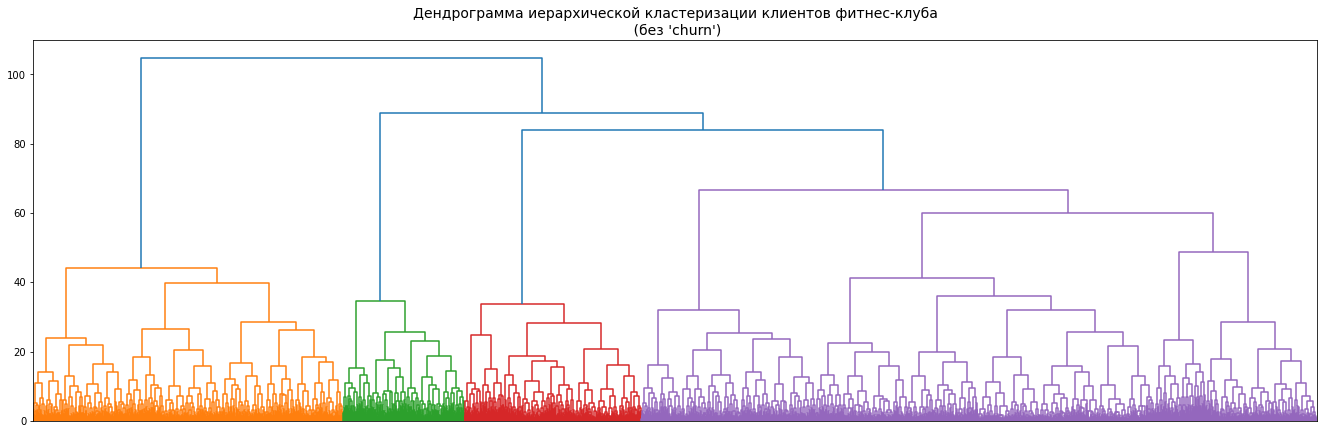

In [31]:
linked = linkage(X_sc, method='ward')
plt.figure(figsize=(23, 7))
dendrogram(linked, orientation='top', no_labels=True)
plt.title(
    "Дендрограмма иерархической кластеризации клиентов фитнес-клуба\n (без 'churn')",
    size=14)
plt.show()

Предложенное оптимальное число кластеров 4. 
Добавим столбец `churn`

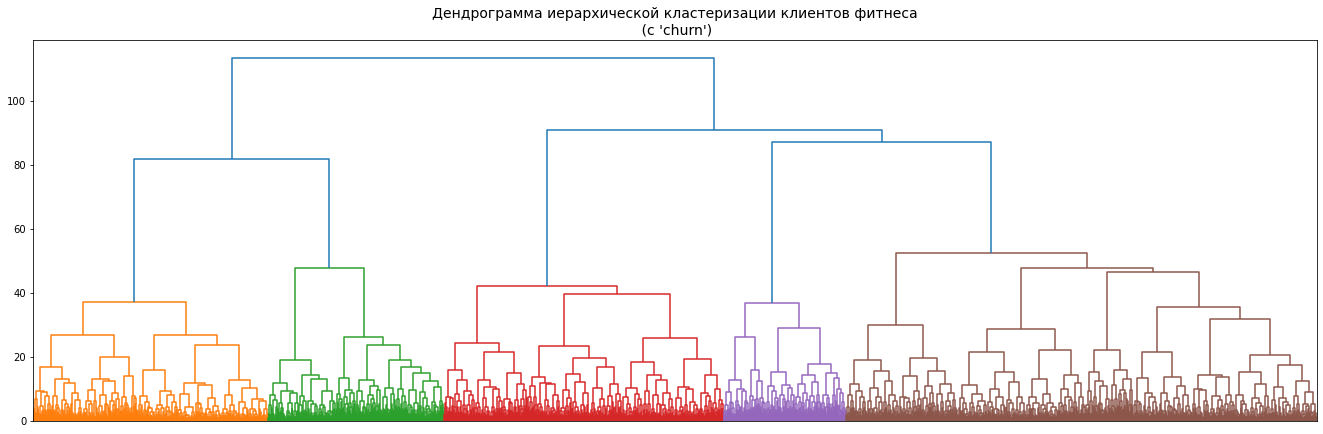

In [32]:
X_sc = scaler.fit_transform(df)
linked = linkage(X_sc, method='ward')
plt.figure(figsize=(23, 7))
dendrogram(linked, orientation='top', no_labels=True)
plt.title(
    "Дендрограмма иерархической кластеризации клиентов фитнеса\n (с 'churn')",
    size=14)
plt.show()

Число кластеров стало 5, что является более корректным вариантом.

### Обучение модели кластеризации (K-Means) и прогноз кластеров клиентов

In [33]:
# на основе дендограммы, выделено 5 кластеров
km = KMeans(n_clusters=5, random_state=0)
# прогноз кластеров для наблюдений
labels = km.fit_predict(X_sc)
# сохранение меток кластеров в поле датасета
df['cluster_km'] = labels
# расчёт метрики силуэта для кластеризации
X_sc = scaler.fit_transform(df)
silhouette_score(X_sc, labels)

0.17411035347503936

Значение метрики оказалось не высоким. Чем ближе к 1, тем качественнее кластеризация.

### Средние значения признаков для кластеров

In [34]:
df.groupby('cluster_km').mean().T

cluster_km,0,1,2,3,4
gender,0.503676,0.492829,0.507917,0.521186,0.518895
near_location,0.000000,0.936115,1.000000,0.996610,0.968023
partner,0.459559,0.764016,0.323995,0.282203,0.744186
promo_friends,0.075368,0.534550,0.213155,0.208475,0.526163
phone,0.917279,0.919166,0.903776,0.904237,0.873547
contract_period,2.069853,10.447197,1.546894,1.882203,8.859012
group_visits,0.211397,0.516297,0.287454,0.452542,0.534884
age,28.522059,29.962190,26.926918,30.237288,29.728198
avg_additional_charges_total,132.741216,161.853561,113.173051,157.988625,162.907495
month_to_end_contract,1.950368,9.477184,1.500609,1.794915,8.155523


Большинсто клиентов фитнес-клуба, попало в кластер №2:
 - мужчин и женщин одинаково;
 - проживают или работают в одном районе;
 - в нём располагаюся самые молодые посетители;
 - остальные признаки выглядет слабее, по сравнению с другими кластерами. 
 
В кластере 0 полностью отсутсвуют телефоны, а отток равен 26%.    
Наиболее надежными выгледят кластеры 1 и 3:
  - кластер №1 имеет самую высокую частосту посещений;
  - возраст примерно равен 30 годам.

### Распределения признаков по кластерам

In [35]:
x = df.drop('churn', axis = 1)
df_plot_cluster = df.copy()  # копирование df
df_plot_cluster['churn'] = df_plot['churn'].replace(
    [1, 0], ['churn', 'active'])  # новое имя для 0 и 1

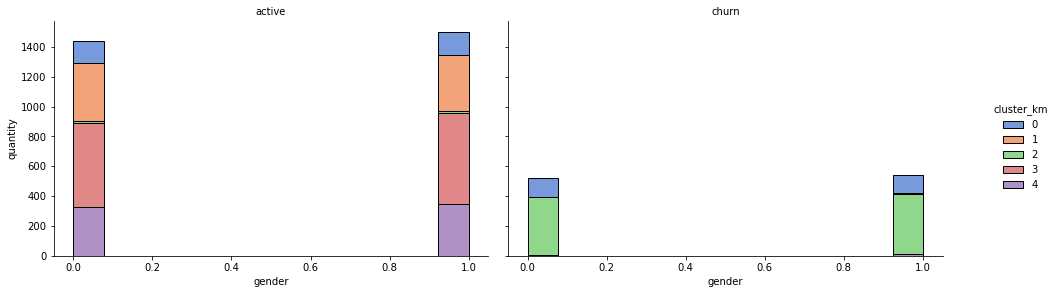

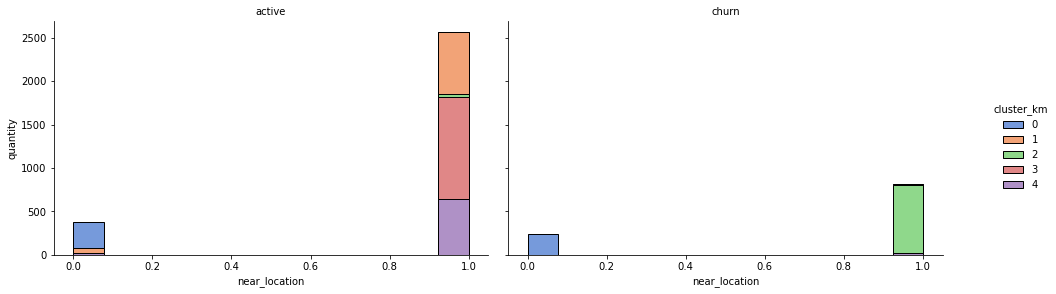

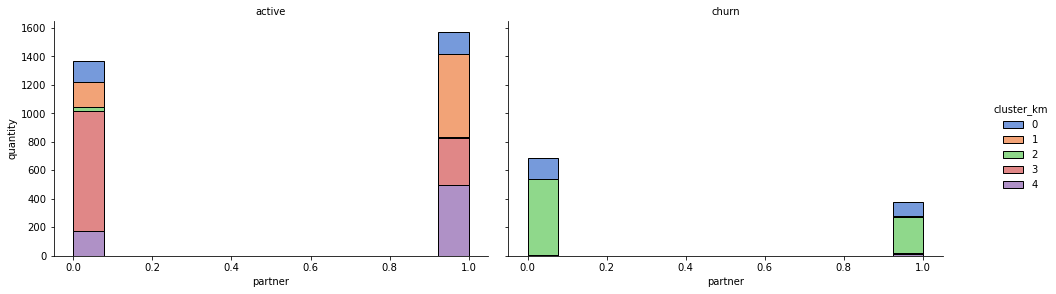

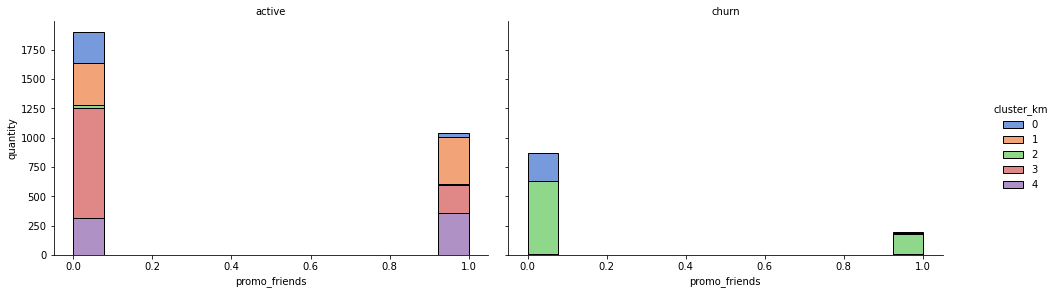

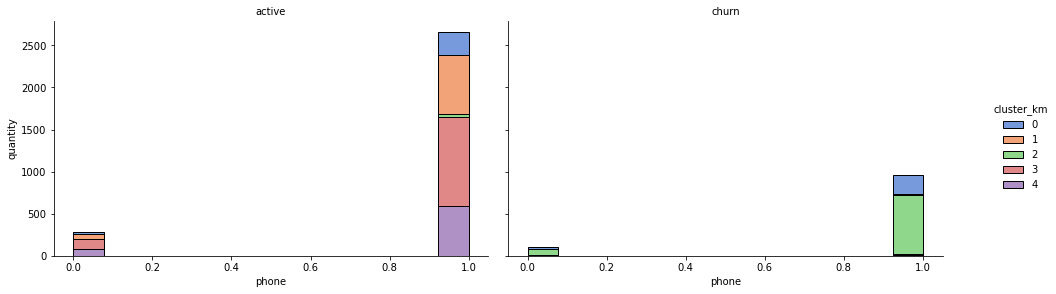

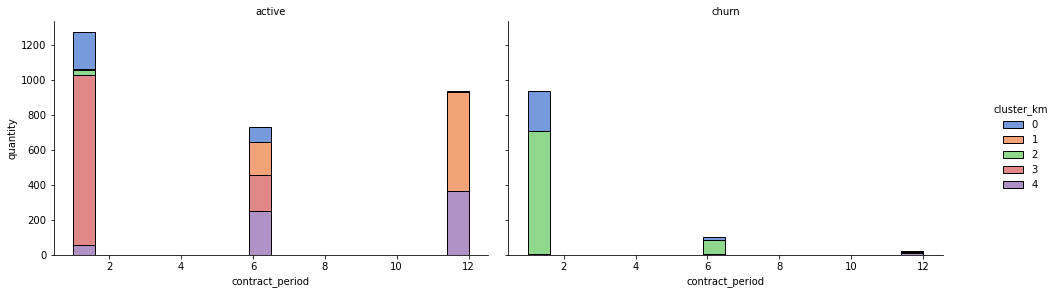

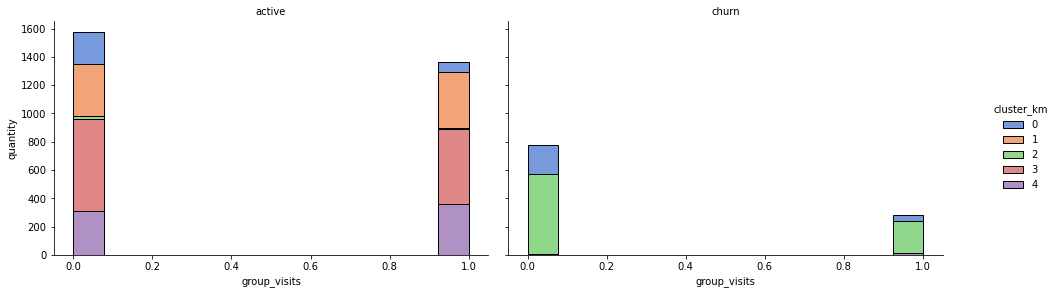

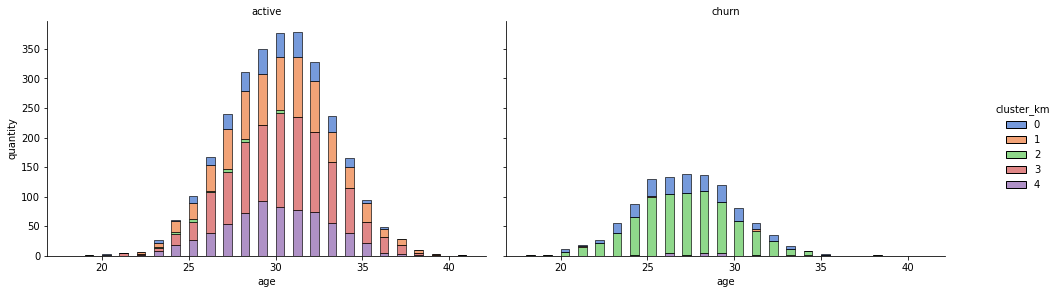

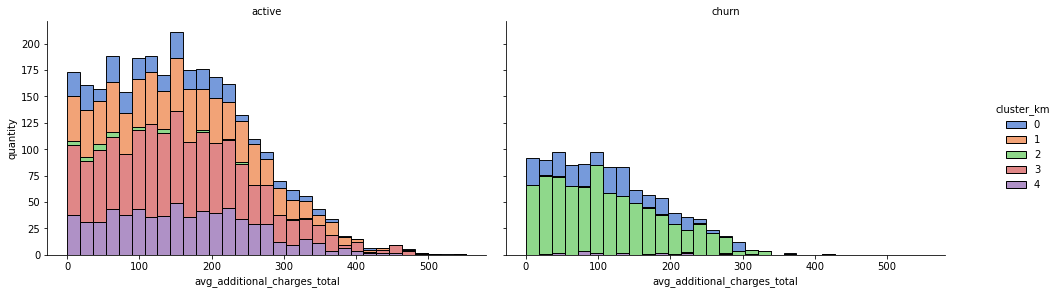

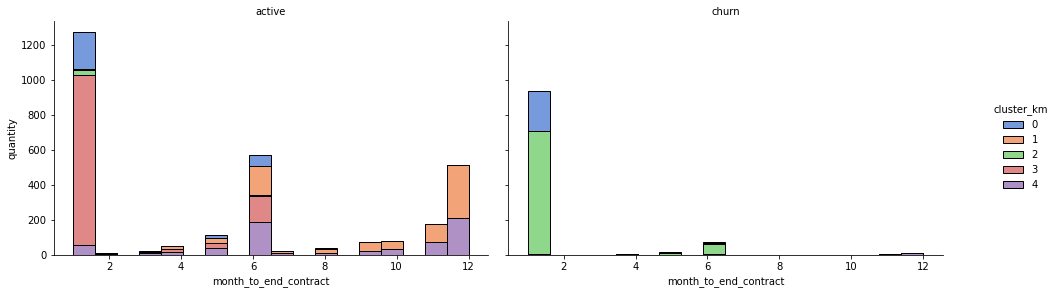

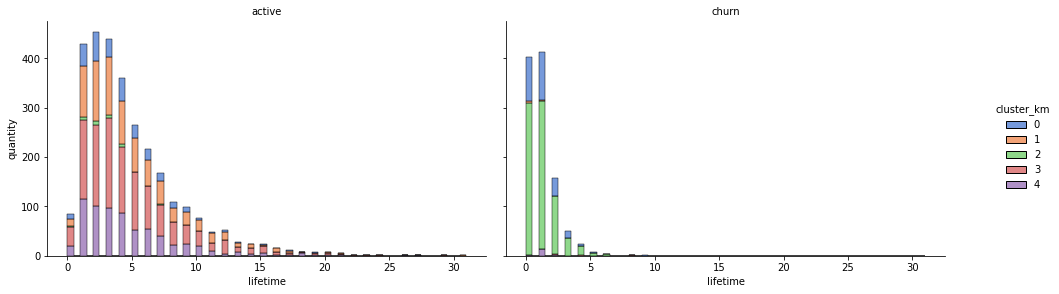

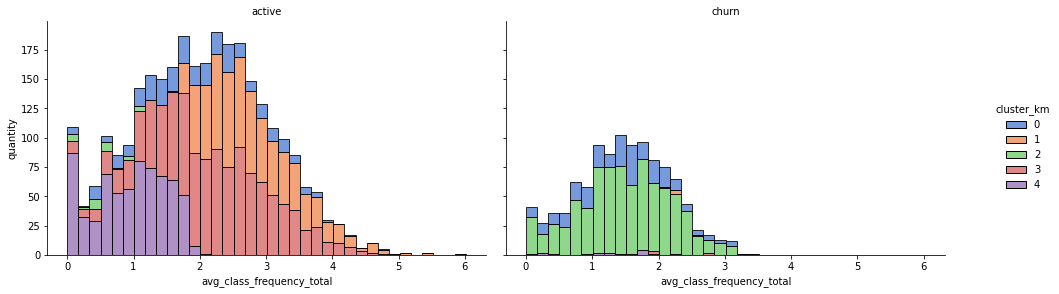

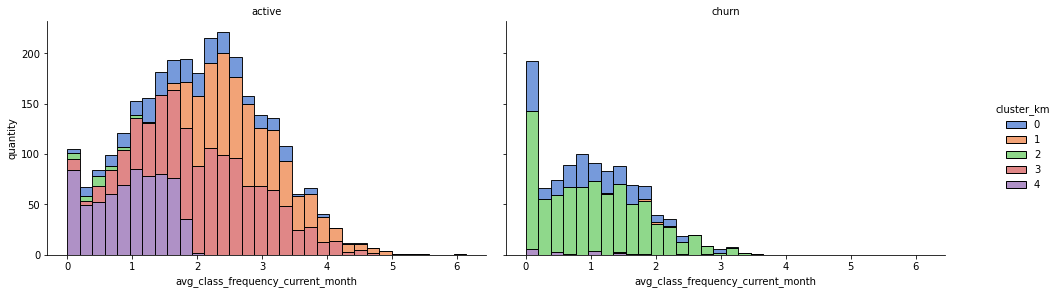

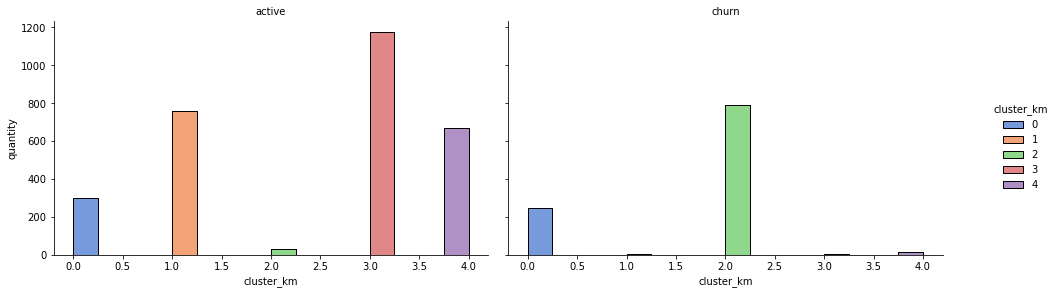

In [36]:
for name in x.columns:
    g = sns.displot(df_plot_cluster,
                    x=name,
                    hue="cluster_km",
                    palette="muted",
                    multiple="stack",
                    col="churn")
    g.fig.set_figwidth(15)
    g.fig.set_figheight(4)
    g.set_axis_labels(name, "quantity")
    g.set_titles("{col_name}")
    plt.show()

Дополнительно можно отметить:
- большинство клиентов живет/работает рядом с фитнес-клубом;
- больше половины клиентов, не являются корпоративными клиентами;
- половина клиентов пришла по акции "приведи друга";
- гистограмма возраста имеет распределение нормального вида, со смещением влево;
- контракты с периодом действия в 1 месяц, чаще заканчивается оттоком;
- гистограмма дополнительных трат имеет отрицательное биномиальное распределение и в 2 раза ниже показателей по действующим клиентам.

### Доля оттока по кластерам

In [41]:
df.groupby('cluster_km').agg({'churn':'mean'}).reset_index()

,cluster_km,churn
0,0,0.450368
1,1,0.007823
2,2,0.961023
3,3,0.003390
4,4,0.024709


Кластер №2, имеет самый высокий показатель оттока, тогда как наиболее лояльными являются кластеры №1 и №3.

## Выводы и рекомендации

### Вывод
1. Название столбцов: переведены в нижний регистр;
2. Тип данных столбца Month_to_end_contract переведён в формат int64;
3. Дубликаты, пропуски и аномалии отсутствуют.

Далее был проведён исследовательский анализ, построено две модели прогнозирования оттока клиентов и выполнена кластеризация клиентов для определения поведенческих групп и показателей оттока.

Сразу бросается несколько факторов оттока:
- приобретение абонемента на 1 месяц.
- не посещение групповых занятий;
- редкое посещение клуба;
- отсутствие специальных предложений;

В итоге картина сложилась такая, мы получили что большинство клиентов уже перестало пользоваться услугами клуба, и это как раз те, кто приобрел абонемент на 1 месяц. Данных клиентов пока не получилось реактивировать.

Далее было обучено две модели по алгоритмам логистической регрессии и случайного леса. Модель логистической регрессии с кастомным порогом = 0.4 на валидационной выборке показала наилучшие метрики.

Дополнительно все клиенты были поделены на кластеры, с помощью K-Means.
Кластер №2 оказался наиболее подверженным к оттоку клиентов, а наиболее успешные кластеры №1 и №3.

### Рекомендация
- сделать более привлекательную сетку тарифов;
- сконцентрироваться на акциях (партнёр, приведи друга);
- предложить пробные групповые занятия новым клиентам;
- реативировать тех, кто уже ушёл;
- изучить товары и услуги, которые пользуются наибольшим спросом, пересмотреть их ценовую политику;
- стараться работать на удержание клиентов, так как возраст клиента в клубе, увеличивает средний чек;
- стараться ориентироваться на клиентов 29+.